# 04. Выделения ролей

---

### Что можно использовать для ролей:

Активность пользователя:

- **n_commits** - сколько коммитов сделал пользователь;
- **n_repos** - сколько репозиториев создал;
- **commits_per_repo** - средняя активность на репозиторий;
- **repo_forks_sum**, **repo_stars_sum**, **repo_open_issues_sum** - косвенные метрики влияния и активности;

Социальная активность** (из графа **followers**):
- followers, following - влиятельность и социальная сеть;
- Центральность узлов в графе **followers_graph** (degree, betweenness, eigenvector centrality) → кто координирует, кто влиятелен;

Взаимодействие в коде (из Co-Commit и Author-Committer):
- Центральность в **co_repo_graph** - кто активно работает с другими;
- Авторство vs коммитер - можно выделить «лидеров» (архитекторов) и «исполнителей» (разработчиков);

---

> Импорты:

In [ ]:
import pandas as pd
from tqdm import tqdm
import networkx as nx
from tqdm import tqdm
from community import community_louvain
from pyvis.network import Network

> Загружаем данные:

In [2]:
df = pd.read_csv("/Users/georgetarasov/Desktop/NIR/github-roles-abm/data/processed/features_for_clustering.csv")

> Загружаем **co_repo_graph**:

In [3]:
co_repo_graph = nx.read_graphml("/Users/georgetarasov/Desktop/NIR/github-roles-abm/data/graphs/co_repo_graph.graphml")

> Вычисляем графовые метрики:

In [ ]:
print("Computing degree centrality...")
degree_centrality = nx.degree_centrality(co_repo_graph)
print("Computing betweenness centrality (approximation)...")
betweenness_centrality = nx.betweenness_centrality(co_repo_graph, k=1000, seed=42)

df['degree_centrality'] = df['id'].map(degree_centrality).fillna(0)
df['betweenness_centrality'] = df['id'].map(betweenness_centrality).fillna(0)


Computing degree centrality...
Computing betweenness centrality (approximation)...


In [10]:
df['betweenness_centrality'].describe()

count    100000.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: betweenness_centrality, dtype: float64

> Сообщества (Louvain):

In [5]:
print("Detecting communities using Louvain...")
partition = community_louvain.best_partition(co_repo_graph)
df['louvain_community'] = df['id'].map(partition).fillna(-1).astype(int)

Detecting communities using Louvain...


> Назначение ролей на основе графа:

In [15]:
def assign_role_graph_based(row):
    # Архитектор: много связей и центр в сети
    if row['degree_centrality'] > 0.02 and row['betweenness_centrality'] > 0.001:
        return "архитектор"
    # Разработчик: активные коммиты, но средний центр
    elif row['n_commits'] > 20:
        return "разработчик"
    # Координатор: центр сети (много связей), мало коммитов
    elif row['degree_centrality'] > 0.01:
        return "координатор"
    # Комментатор: много открытых issue
    elif row['repo_open_issues_sum'] > 5:
        return "комментатор"
    # Новичок: нет коммитов, мало репозиториев
    elif row['n_commits'] == 0 and row['n_repos'] <= 1:
        return "новичок"
    else:
        return "остальные"

df['role_graph_based'] = df.apply(assign_role_graph_based, axis=1)

# Проверим распределение ролей
print(df['role_graph_based'].value_counts())

role_graph_based
новичок        70296
остальные      21100
разработчик     8111
комментатор      493
Name: count, dtype: int64


> Визуализация интерактивного графа:

Assigning node colors: 100%|██████████| 1346/1346 [00:00<00:00, 13061.50it/s]


Computing layout (это может занять время)...


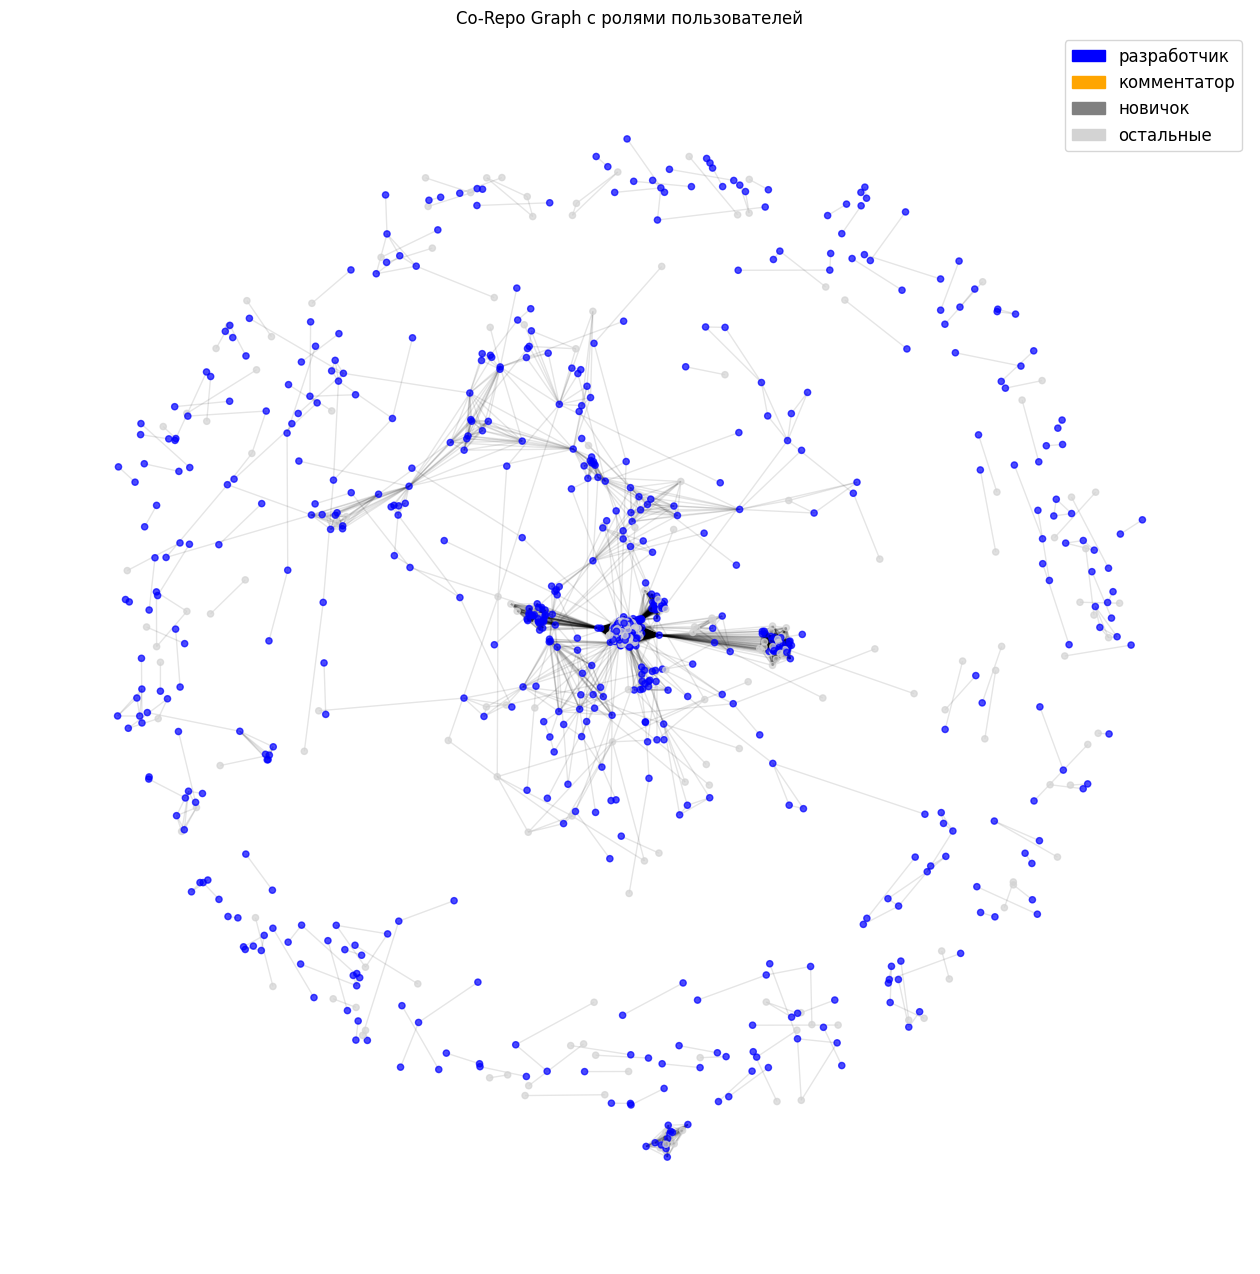

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
from tqdm import tqdm
from matplotlib.patches import Patch

# Ограничиваем количество узлов
MAX_NODES = co_repo_graph.number_of_nodes()
H = co_repo_graph.copy()

# Расставляем роли для узлов с прогрессом
role_colors = {
    "разработчик": "blue",
    "комментатор": "orange",
    "новичок": "gray",
    "остальные": "lightgray"
}

node_colors = []
for node in tqdm(H.nodes(), desc="Assigning node colors"):
    role_series = df.loc[df['id'] == int(node), 'role_graph_based']
    if not role_series.empty:
        role = role_series.values[0]
        node_colors.append(role_colors.get(role, "lightgray"))
    else:
        node_colors.append("lightgray")

# Позиции узлов (Layout)
print("Computing layout (это может занять время)...")
pos = nx.spring_layout(H, seed=42)


# Отрисовка
plt.figure(figsize=(16, 16))
nx.draw_networkx_nodes(H, pos, node_color=node_colors, node_size=20, alpha=0.7)
nx.draw_networkx_edges(H, pos, alpha=0.1)
plt.axis('off')
plt.title("Co-Repo Graph с ролями пользователей")

# Легенда
legend_elements = [Patch(color=color, label=role) for role, color in role_colors.items()]
plt.legend(handles=legend_elements, loc='upper right', fontsize=12)

plt.show()


> Визуализация с pyvis:

In [23]:
# from pyvis.network import Network
# import random
# from tqdm import tqdm

# # -----------------------------
# # 1. Создаем подграф для визуализации
# # -----------------------------
# MAX_NODES = 5000  # интерактивно можно около 5k узлов, больше может тормозить
# if co_repo_graph.number_of_nodes() > MAX_NODES:
#     nodes = random.sample(list(co_repo_graph.nodes()), MAX_NODES)
#     H = co_repo_graph.subgraph(nodes).copy()
# else:
#     H = co_repo_graph.copy()

# # -----------------------------
# # 2. Создаем PyVis Network
# # -----------------------------
# net = Network(height="900px", width="100%", notebook=True, bgcolor="#222222", font_color="white")
# net.force_atlas_2based()  # интерактивный "разбрасыватель" узлов

# # -----------------------------
# # 3. Цвета ролей
# # -----------------------------
# role_colors = {
#     "разработчик": "blue",
#     "комментатор": "orange",
#     "новичок": "gray",
#     "остальные": "lightgray"
# }

# # -----------------------------
# # 4. Добавляем узлы
# # -----------------------------
# for node in tqdm(H.nodes(), desc="Adding nodes"):
#     role_series = df.loc[df['id']==int(node), 'role_graph_based']
#     if not role_series.empty:
#         role = role_series.values[0]
#     else:
#         role = "остальные"

#     # Редкие роли крупнее
#     size = 15
#     if role in ["комментатор", "новичок"]:
#         size = 30

#     net.add_node(
#         n_id=str(node),
#         label=str(node),
#         title=f"ID: {node}\nRole: {role}",
#         color=role_colors.get(role, "lightgray"),
#         size=size
#     )

# # -----------------------------
# # 5. Добавляем ребра
# # -----------------------------
# for u, v, data in tqdm(H.edges(data=True), desc="Adding edges"):
#     net.add_edge(str(u), str(v), value=data.get('weight', 1), color="#888888", physics=True)

# # -----------------------------
# # 6. Настройки
# # -----------------------------
# net.set_options("""
# var options = {
#   "nodes": {
#     "borderWidth": 1,
#     "borderWidthSelected": 2,
#     "font": {"size":12, "color":"white"}
#   },
#   "edges": {
#     "color": {"inherit": true},
#     "smooth": {"type": "continuous"}
#   },
#   "physics": {
#     "enabled": true,
#     "barnesHut": {"gravitationalConstant": -8000, "centralGravity": 0.3, "springLength": 95}
#   }
# }
# """)

# # -----------------------------
# # 7. Сохраняем и отображаем
# # -----------------------------
# net.show("co_repo_graph_roles_interactive.html")
